In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from pandas import DataFrame
from pandas import Series
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import cross_val_score
from scipy.sparse import csr_matrix, hstack
from sklearn.metrics import log_loss

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
ls Data

app_events.csv                    gender_age_train.csv
app_events.csv.zip                gender_age_train.csv.zip
app_labels.csv                    label_categories.csv
app_labels.csv.zip                label_categories.csv.zip
events.csv                        phone_brand_device_model.csv
events.csv.zip                    phone_brand_device_model.csv.zip
gender_age_test.csv               sample_submission.csv
gender_age_test.csv.zip           sample_submission.csv.zip


In [3]:
gatrain = pd.read_csv('Data/gender_age_train.csv',
                      index_col='device_id')
gatest = pd.read_csv('Data/gender_age_test.csv',
                     index_col = 'device_id')
phone = pd.read_csv('Data/phone_brand_device_model.csv')
# Get rid of duplicate device ids in phone
phone = phone.drop_duplicates('device_id',keep='first').set_index('device_id')
event = pd.read_csv('Data/events.csv',
                     parse_dates=['timestamp'], index_col='event_id')
app_event = pd.read_csv('Data/app_events.csv', 
                        usecols=['event_id','app_id','is_active'],
                        dtype={'is_active':bool})
app_label = pd.read_csv('Data/app_labels.csv')
label_cat = pd.read_csv('Data/label_categories.csv')

In [4]:
gatrain['trainrow'] = np.arange(gatrain.shape[0])
gatest['testrow'] = np.arange(gatest.shape[0])
print gatrain.head()
print gatest.head()

                     gender  age   group  trainrow
device_id                                         
-8076087639492063270      M   35  M32-38         0
-2897161552818060146      M   35  M32-38         1
-8260683887967679142      M   35  M32-38         2
-4938849341048082022      M   30  M29-31         3
 245133531816851882       M   30  M29-31         4
                      testrow
device_id                    
 1002079943728939269        0
-1547860181818787117        1
 7374582448058474277        2
-6220210354783429585        3
-5893464122623104785        4


In [5]:
brandencoder = LabelEncoder().fit(phone.phone_brand)
phone['brand'] = brandencoder.transform(phone['phone_brand'])
gatrain['brand'] = phone['brand']
gatest['brand'] = phone['brand']
mtrain_brand = csr_matrix((np.ones(gatrain.shape[0]), 
                       (gatrain.trainrow, gatrain.brand)))
mtest_brand = csr_matrix((np.ones(gatest.shape[0]), 
                       (gatest.testrow, gatest.brand)))
print('Brand features: train shape {}, test shape {}'.format(mtrain_brand.shape, mtest_brand.shape))
print gatrain.head()
print gatest.head()

Brand features: train shape (74645, 131), test shape (112071, 131)
                     gender  age   group  trainrow  brand
device_id                                                
-8076087639492063270      M   35  M32-38         0     51
-2897161552818060146      M   35  M32-38         1     51
-8260683887967679142      M   35  M32-38         2     51
-4938849341048082022      M   30  M29-31         3     51
 245133531816851882       M   30  M29-31         4     51
                      testrow  brand
device_id                           
 1002079943728939269        0     51
-1547860181818787117        1     51
 7374582448058474277        2     31
-6220210354783429585        3     31
-5893464122623104785        4     51


In [6]:
m = phone.phone_brand.str.cat(phone.device_model)
modelencoder = LabelEncoder().fit(m)
phone['model'] = modelencoder.transform(m)
gatrain['model'] = phone['model']
gatest['model'] = phone['model']
mtrain_model = csr_matrix((np.ones(gatrain.shape[0]), 
                       (gatrain.trainrow, gatrain.model)))
mtest_model = csr_matrix((np.ones(gatest.shape[0]), 
                       (gatest.testrow, gatest.model)))
print('Model features: train shape {}, test shape {}'.format(mtrain_model.shape, mtest_model.shape))
print phone.head()
print gatrain.head()
print gatest.head()

Model features: train shape (74645, 1667), test shape (112071, 1667)
                     phone_brand   device_model  brand  model
device_id                                                    
-8890648629457979026          小米             红米     51    858
 1277779817574759137          小米           MI 2     51    843
 5137427614288105724          三星      Galaxy S4     15    371
 3669464369358936369       SUGAR           时尚手机      9    166
-5019277647504317457          三星  Galaxy Note 2     15    347
                     gender  age   group  trainrow  brand  model
device_id                                                       
-8076087639492063270      M   35  M32-38         0     51    843
-2897161552818060146      M   35  M32-38         1     51    843
-8260683887967679142      M   35  M32-38         2     51    843
-4938849341048082022      M   30  M29-31         3     51    865
 245133531816851882       M   30  M29-31         4     51    847
                      testrow  brand  mode

In [7]:
appencoder = LabelEncoder().fit(app_event.app_id)
app_event['app'] = appencoder.transform(app_event.app_id)
napps = len(appencoder.classes_)
device_app = (app_event.merge(event[['device_id']], how='left',left_on='event_id',right_index=True)
                       .groupby(['device_id','app'])['app'].agg(['size'])
                       .merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
                       .merge(gatest[['testrow']], how='left', left_index=True, right_index=True)
                       .reset_index())
device_app.head()

,device_id,app,size,trainrow,testrow
0,-9222956879900151005,548,18,21594.0,NaN
1,-9222956879900151005,1096,18,21594.0,NaN
2,-9222956879900151005,1248,26,21594.0,NaN
3,-9222956879900151005,1545,12,21594.0,NaN
4,-9222956879900151005,1664,18,21594.0,NaN


In [8]:
d = device_app.dropna(subset=['trainrow'])
mtrain_app = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.app)), 
                      shape=(gatrain.shape[0],napps))
d = device_app.dropna(subset=['testrow'])
mtest_app = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.app)), 
                      shape=(gatest.shape[0],napps))
print('Apps data: train shape {}, test shape {}'.format(mtrain_app.shape, mtest_app.shape))

Apps data: train shape (74645, 19237), test shape (112071, 19237)


In [9]:
app_label = pd.read_csv('Data/app_labels.csv')

In [10]:
app_label = app_label.loc[app_label.app_id.isin(app_event.app_id.unique())]
app_label['app'] = appencoder.transform(app_label.app_id)
labelencoder = LabelEncoder().fit(app_label.label_id)
app_label['label'] = labelencoder.transform(app_label.label_id)
nlabels = len(labelencoder.classes_)
app_label.head()

,app_id,label_id,app,label
0,7324884708820027918,251,17355,207
1,-4494216993218550286,251,4618,207
2,6058196446775239644,406,15548,247
3,6058196446775239644,407,15548,248
4,8694625920731541625,406,18689,247


In [11]:
device_label = (device_app[['device_id','app']]
                .merge(app_label[['app','label']])
                .groupby(['device_id','label'])['app'].agg(['size'])
                .merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
                .merge(gatest[['testrow']], how='left', left_index=True, right_index=True)
                .reset_index())
device_label.head()

,device_id,label,size,trainrow,testrow
0,-9222956879900151005,117,1,21594.0,NaN
1,-9222956879900151005,120,1,21594.0,NaN
2,-9222956879900151005,126,1,21594.0,NaN
3,-9222956879900151005,138,2,21594.0,NaN
4,-9222956879900151005,147,2,21594.0,NaN


In [12]:
d = device_label.dropna(subset=['trainrow'])
mtrain_label = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.label)), 
                      shape=(gatrain.shape[0],nlabels))
d = device_label.dropna(subset=['testrow'])
mtest_label = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.label)), 
                      shape=(gatest.shape[0],nlabels))
print('Labels data: train shape {}, test shape {}'.format(mtrain_label.shape, mtest_label.shape))

Labels data: train shape (74645, 492), test shape (112071, 492)


In [13]:
mtrain = hstack((mtrain_brand, mtrain_model, mtrain_app, mtrain_label), format='csr')
mtest =  hstack((mtest_brand, mtest_model, mtest_app, mtest_label), format='csr')
print('All features: train shape {}, test shape {}'.format(mtrain.shape, mtest.shape))

All features: train shape (74645, 21527), test shape (112071, 21527)


In [14]:
targetencoder = LabelEncoder().fit(gatrain.group)
y = targetencoder.transform(gatrain.group)
nclasses = len(targetencoder.classes_)
print nclasses

12


In [15]:
def score(clf, X=mtrain, cv=5, scoring='log_loss'):
    return cross_val_score(clf, X, y, cv=cv, scoring=scoring)

0.0201172620027 2.28844405252


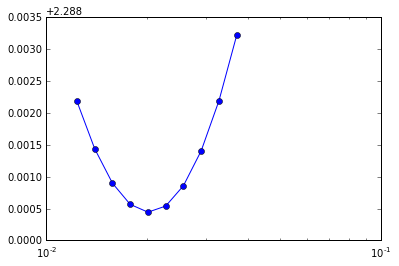

In [17]:
Cs = np.logspace(-4,-3,10, base = 3.0)
res = []
best_C, best_res = 0, None
for C in Cs:
    scores = -1 * score(LogisticRegression(C = C))
    temp_res = scores.mean()
    res.append(temp_res)
    if not best_res or temp_res < best_res:
        best_res, best_C = temp_res, C
print best_C, best_res
plt.semilogx(Cs, res,'-o')

0.016681005372 2.28248670863


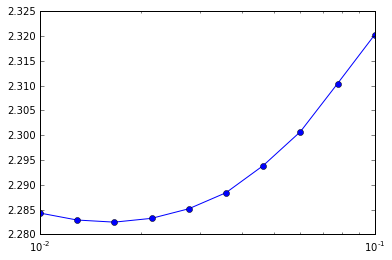

In [18]:
Cs = np.logspace(-2,-1,10, base = 10.0)
res = []
best_C, best_res = 0, None
for C in Cs:
    scores = -1 * score(LogisticRegression(C=C, multi_class='multinomial',solver='lbfgs'))
    temp_res = scores.mean()
    res.append(temp_res)
    if not best_res or temp_res < best_res:
        best_res, best_C = temp_res, C
print best_C, best_res
plt.semilogx(Cs, res,'-o')

0.0278255940221 2.39976240829


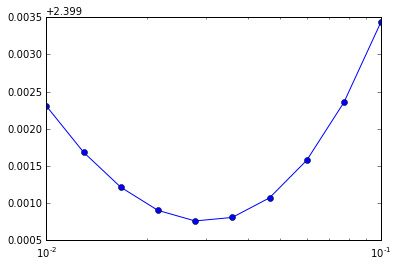

In [19]:
mtrain_bm = hstack((mtrain_brand, mtrain_model), format='csr')
Cs = np.logspace(-2,-1,10, base = 10.0)
res = []
best_C, best_res = 0, None
for C in Cs:
    scores = -1 * score(LogisticRegression(C=C, multi_class='multinomial',solver='lbfgs'), X=mtrain_bm)
    temp_res = scores.mean()
    res.append(temp_res)
    if not best_res or temp_res < best_res:
        best_res, best_C = temp_res, C
print best_C, best_res
plt.semilogx(Cs, res,'-o')

In [21]:
label_cat = label_cat.loc[label_cat.label_id.isin(app_label.label_id.unique())]
catencoder = LabelEncoder().fit(label_cat.category)
label_cat['cat'] = catencoder.transform(label_cat.category)
ncats = len(catencoder.classes_)
print ncats

label_cat['label'] = labelencoder.transform(label_cat.label_id)

458


In [22]:
# Try to make use of category
device_cat = (device_app[['device_id','app']]
                .merge(app_label[['app','label']])
                .merge(label_cat[['label', 'cat']])
                .groupby(['device_id','cat'])['cat'].agg(['size'])
                .merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
                .merge(gatest[['testrow']], how='left', left_index=True, right_index=True)
                .reset_index())
device_cat.head()

,device_id,cat,size,trainrow,testrow
0,-9222956879900151005,1,1,21594.0,NaN
1,-9222956879900151005,10,1,21594.0,NaN
2,-9222956879900151005,16,31,21594.0,NaN
3,-9222956879900151005,38,1,21594.0,NaN
4,-9222956879900151005,57,1,21594.0,NaN


In [23]:
d = device_cat.dropna(subset=['trainrow'])
mtrain_cat = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.cat)),
                    shape=(gatrain.shape[0], ncats))
d = device_cat.dropna(subset=['testrow'])
mtest_cat = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.cat)), 
                      shape=(gatest.shape[0],ncats))

0.0215443469003 2.30908855011


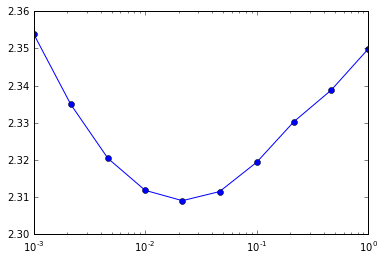

In [24]:
mtrain_bml = hstack((mtrain_brand, mtrain_model, mtrain_label), format='csr')
Cs = np.logspace(-3,0,10, base = 10.0)
res = []
best_C, best_res = 0, None
for C in Cs:
    scores = -1 * score(LogisticRegression(C=C, multi_class='multinomial',solver='lbfgs'), X=mtrain_bml)
    temp_res = scores.mean()
    res.append(temp_res)
    if not best_res or temp_res < best_res:
        best_res, best_C = temp_res, C
print best_C, best_res
plt.semilogx(Cs, res,'-o')

0.0215443469003 2.30974279033


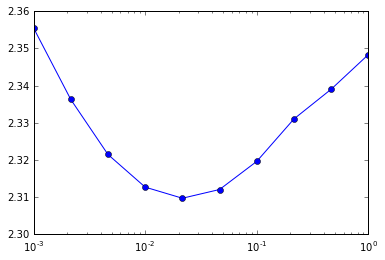

In [25]:
mtrain_bmc = hstack((mtrain_brand, mtrain_model, mtrain_cat), format='csr')
Cs = np.logspace(-3,0,10, base = 10.0)
res = []
best_C, best_res = 0, None
for C in Cs:
    scores = -1 * score(LogisticRegression(C=C, multi_class='multinomial',solver='lbfgs'), X=mtrain_bmc)
    temp_res = scores.mean()
    res.append(temp_res)
    if not best_res or temp_res < best_res:
        best_res, best_C = temp_res, C
print best_C, best_res
plt.semilogx(Cs, res,'-o')

In [26]:
"""mtrain_bmc and mtrain_bml give about the same result, which makes sense because label and categories 
   are about the same thing. I will just use category."""

'mtrain_bmc and mtrain_bml give about the same result, which makes sense because label and categories \n   are about the same thing. I will just use category.'

In [28]:
def get_hour(x):
    return x.hour
event = pd.read_csv('Data/events.csv',
                     parse_dates=['timestamp'], index_col='event_id')
event['hour'] = event.timestamp.map(get_hour)
event.head()

,device_id,timestamp,longitude,latitude,hour
event_id,,,,,
1,29182687948017175,2016-05-01 00:55:25,121.38,31.24,0
2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,0
3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70,0
4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28,0
5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66,0


In [29]:
event = (event.groupby(['device_id', 'hour']).agg({'hour': 'size'})
          .groupby(level=0).apply(lambda x: x / float(x.sum())))
event = event.rename(columns={'hour':'hour_pct'})

In [30]:
# Add events time (hour) as a feature
event = (event.merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
          .merge(gatest[['testrow']], how='left', left_index=True, right_index=True)
          .reset_index())
event.head()

,device_id,hour,hour_pct,trainrow,testrow
0,-9222956879900151005,7,0.030769,21594.0,NaN
1,-9222956879900151005,11,0.107692,21594.0,NaN
2,-9222956879900151005,12,0.200000,21594.0,NaN
3,-9222956879900151005,13,0.046154,21594.0,NaN
4,-9222956879900151005,14,0.076923,21594.0,NaN


In [31]:
d = event.dropna(subset=['trainrow'])
mtrain_hour = csr_matrix((d.hour_pct, (d.trainrow, d.hour)),
                      shape=(gatrain.shape[0], 24))
d = event.dropna(subset=['testrow'])
mtest_hour = csr_matrix((d.hour_pct, (d.testrow, d.hour)),
                     shape=(gatest.shape[0], 24))
print 'Events hour pct: train shape {}, test shape {}'.format(mtrain_hour.shape, mtest_hour.shape)

Events hour pct: train shape (74645, 24), test shape (112071, 24)


0.0215443469003 2.30945538196


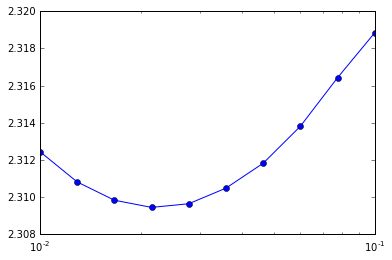

In [32]:
mtrain_bmch = hstack((mtrain_brand, mtrain_model, mtrain_cat, mtrain_hour), format='csr')
Cs = np.logspace(-2,-1,10, base = 10.0)
res = []
best_C, best_res = 0, None
for C in Cs:
    scores = -1 * score(LogisticRegression(C=C, multi_class='multinomial',solver='lbfgs'), X=mtrain_bmch)
    temp_res = scores.mean()
    res.append(temp_res)
    if not best_res or temp_res < best_res:
        best_res, best_C = temp_res, C
print best_C, best_res
plt.semilogx(Cs, res,'-o')

0.016681005372 2.28228563884


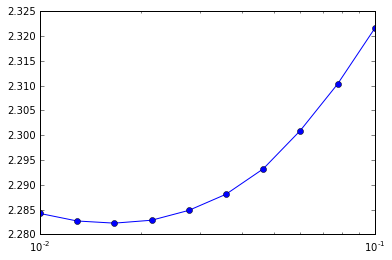

In [33]:
mtrain_bmach = hstack((mtrain_brand, mtrain_model, mtrain_app, mtrain_cat, mtrain_hour), format='csr')
Cs = np.logspace(-2,-1,10, base = 10.0)
res = []
best_C, best_res = 0, None
for C in Cs:
    scores = -1 * score(LogisticRegression(C=C, multi_class='multinomial',solver='lbfgs'), X=mtrain_bmach)
    temp_res = scores.mean()
    res.append(temp_res)
    if not best_res or temp_res < best_res:
        best_res, best_C = temp_res, C
print best_C, best_res
plt.semilogx(Cs, res,'-o')